In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dnsmex.dxsm_data import dataset_dict, pcp_df_of_nickname


### Look at specific data sets

In [2]:
pcp_df = pcp_df_of_nickname("v1tang", add_shm_outputs=False)

Loading /Users/matsen/data/v3/tang-deepshm-prod-NoWinCheck_igh_pcp_2024-10-29_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('B13', '77'), ('CLL1697', '43875'), ('CLL2056', '18535')]


<Axes: xlabel='count', ylabel='max family size'>

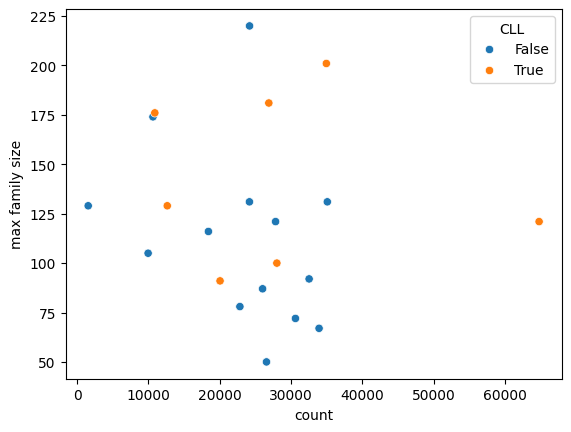

In [3]:
summary_rows = []

for sample_id, group in pcp_df.groupby("sample_id"):
    summary_rows.append({
        "sample_id": sample_id,
        "95 quantile family size": group.groupby("family").size().quantile(0.95),
        "max family size": group.groupby("family").size().max(),
        "count": len(group),
        "CLL": sample_id.startswith("CLL"),
    })

summary_df = pd.DataFrame(summary_rows)
sns.scatterplot(data=summary_df, x="count", y="max family size", hue="CLL")

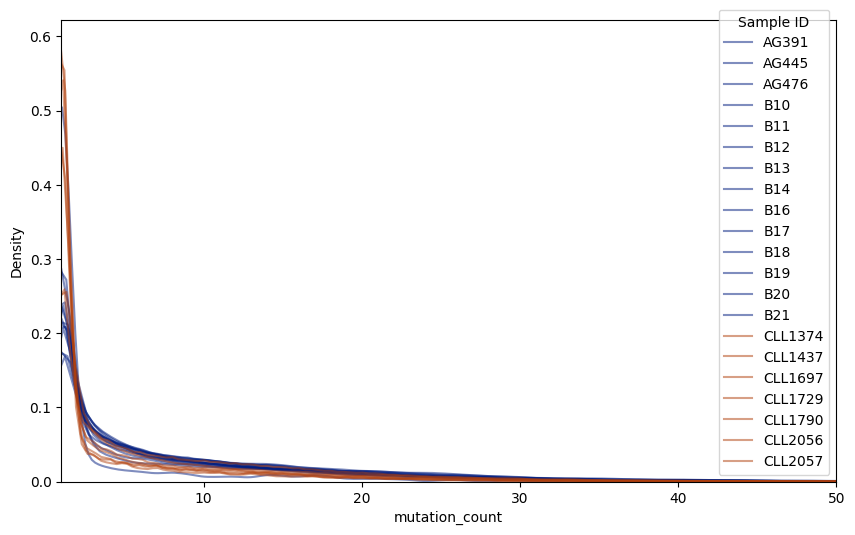

In [4]:
pcp_df["mutation_count"] = [sum(1 for a, b in zip(parent, child) if a != b) for parent, child in zip(pcp_df["parent_heavy"] + pcp_df["parent_light"], pcp_df["child_heavy"] + pcp_df["child_light"])]
pcp_df["CLL"] = pcp_df["sample_id"].str.startswith("CLL")

plt.figure(figsize=(10, 6))
palette = sns.color_palette("dark", 2)

# Iterate through each sample_id and plot with the appropriate color
for sample_id, group in pcp_df.groupby("sample_id"):
    cll_status = group['CLL'].iloc[0]
    sns.kdeplot(data=group, x="mutation_count", label=sample_id, color=palette[int(cll_status)], common_norm=False, alpha=0.5, bw_adjust=0.5)

plt.legend(title="Sample ID")
plt.xlim(1, 50)
plt.show()

In [5]:
sample_ids = pcp_df["sample_id"].unique()
# pick a random 20% of the sample_ids

holdout_sample_ids = np.random.choice(sample_ids, size=int(0.2 * len(sample_ids)), replace=False)

# sum the number of rows of pcp_df where sample_id is in holdout_sample_ids
holdout_count = sum(pcp_df["sample_id"].isin(holdout_sample_ids))
train_count = len(pcp_df) - holdout_count

# print percentages
print(f"train: {train_count / len(pcp_df) * 100:.2f}%")
# sorted holdout_sample_ids
print(sorted(holdout_sample_ids))


train: 80.92%
['AG391', 'B13', 'B18', 'CLL1790']


### Summarize all data

In [6]:
rows = []

datasets_used = ["v1tangCC", "v1jaffePairedCC", "v1vanwinklelightTrainCC1m", "v1rodriguez"]

for nickname in datasets_used:
    if not (nickname.startswith("v") or nickname.startswith("jaffeTangDnsmSim")):
        continue
    pcp_df = pcp_df_of_nickname(nickname, add_shm_outputs=False)
    rows.append({
        "nickname": nickname,
        "pcps": len(pcp_df),
        "samples": len(pcp_df["sample_id"].unique()),
        "families": len(pcp_df["family"].unique()),
    })

summary_df = pd.DataFrame(rows)
summary_df

Loading /Users/matsen/data/v3/tang-deepshm-prod-NoWinCheck_igh_pcp_2024-10-29_MASKED_NI_ConsCys_no-naive_DXSMVALID.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('B13', '77'), ('CLL1697', '43875'), ('CLL2056', '18535')]
Loading /Users/matsen/data/v3/wyatt-10x-1p5m_fs-all-NoWinCheck-UnmutInv-GTR-paired-merged_pcp_2024-11-21_DXSMVALID_no-naive_ConsCys_HL.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('d4', '213393')]
Loading /Users/matsen/data/v3/v3convert_vanwinkle-170-igk_pcp_2025-02-22_MASKED_NI_train_DXSMVALID_ConsCys_no-naive_downsample_500k_CONCAT_vanwinkle-170-igl_pcp_2025-02-25_MASKED_NI_train_DXSMVALID_ConsCys_no-naive_downsample_500k.csv.gz
Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


,nickname,pcps,samples,families
0,v1tangCC,651899,21,45267
1,v1jaffePairedCC,209599,4,50776
2,v1vanwinklelightTrainCC1m,1000000,330,2658
3,v1rodriguez,21752,50,3071


In [7]:
summary_df.to_csv("~/data/dasm_summary.csv", index=False)

In [8]:
def mutation_count(parent, child):
    """Return the fraction of sites that differ between the parent and child sequences."""
    return sum(
        1
        for p, c in zip(parent, child)
        if p != c and p != "N" and c != "N"
    )

def mutation_count_median_of_nickname(multi_nickname):
    # split the multi_nickname into individual nicknames
    nicknames = multi_nickname.split("+")
    # get the individual pcp_df for each nickname and cat them together
    pcp_df = pd.concat(
        [pcp_df_of_nickname(nickname, add_shm_outputs=False) for nickname in nicknames]
    )
    pcp_df["mutation_count"] = pcp_df.apply(
        lambda row: mutation_count(row["parent_heavy"] + row["parent_light"], row["child_heavy"] + row["child_light"]),
        axis=1
    )
    return int(pcp_df["mutation_count"].median())

In [9]:
for_table = summary_df.copy()
for_table["purpose"] = "train"
for_table.loc[for_table["nickname"] == "v1rodriguez", "purpose"] = "test"
# sort for_table by pcps
for_table = for_table.sort_values("pcps", ascending=True)
for_table = for_table.sort_values("purpose", ascending=False)

for_table["median mutations"] = for_table["nickname"].apply(mutation_count_median_of_nickname)

# remove v1 from anywhere in the nickname
for_table["nickname"] = for_table["nickname"].str.replace("v1", "")
for_table = for_table.set_index("purpose").reset_index()
# format the pcps and families columns with commas
for_table["pcps"] = for_table["pcps"].apply(lambda x: f"{x:,}")
for_table["families"] = for_table["families"].apply(lambda x: f"{x:,}")

Loading /Users/matsen/data/v3/wyatt-10x-1p5m_fs-all-NoWinCheck-UnmutInv-GTR-paired-merged_pcp_2024-11-21_DXSMVALID_no-naive_ConsCys_HL.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('d4', '213393')]
Loading /Users/matsen/data/v3/tang-deepshm-prod-NoWinCheck_igh_pcp_2024-10-29_MASKED_NI_ConsCys_no-naive_DXSMVALID.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('B13', '77'), ('CLL1697', '43875'), ('CLL2056', '18535')]
Loading /Users/matsen/data/v3/v3convert_vanwinkle-170-igk_pcp_2025-02-22_MASKED_NI_train_DXSMVALID_ConsCys_no-naive_downsample_500k_CONCAT_vanwinkle-170-igl_pcp_2025-02-25_MASKED_NI_train_DXSMVALID_ConsCys_no-naive_downsample_500k.csv.gz
Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


In [10]:
# set column titles to be purpose, name, PCPs, samples, families
for_table.columns = ["purpose", "name", "PCPs", "samples", "clonal families", "median mutations"]
for_table = for_table[["purpose", "name", "samples", "clonal families", "PCPs", "median mutations"]]

for_table


,purpose,name,samples,clonal families,PCPs,median mutations
0,train,jaffePairedCC,4,"50,776","209,599",7
1,train,tangCC,21,"45,267","651,899",2
2,train,vanwinklelightTrainCC1m,330,"2,658","1,000,000",2
3,test,rodriguez,50,"3,071","21,752",7


In [11]:
# format for_table as a latex table without index. wrap the "name" column in \texttt{}
for_table["name"] = for_table["name"].apply(lambda x: f"\\texttt{{{x}}}")
print(for_table.to_latex(index=False))

\begin{tabular}{llrllr}
\toprule
purpose & name & samples & clonal families & PCPs & median mutations \\
\midrule
train & \texttt{jaffePairedCC} & 4 & 50,776 & 209,599 & 7 \\
train & \texttt{tangCC} & 21 & 45,267 & 651,899 & 2 \\
train & \texttt{vanwinklelightTrainCC1m} & 330 & 2,658 & 1,000,000 & 2 \\
test & \texttt{rodriguez} & 50 & 3,071 & 21,752 & 7 \\
\bottomrule
\end{tabular}



## Looking at specific data sets in more detail

In [12]:
pcp_df = pcp_df_of_nickname("v1rodriguez", add_shm_outputs=False)
pcp_df["v_family_heavy"].value_counts()

Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


v_family_heavy
IGHV3    9983
IGHV4    5246
IGHV1    4328
IGHV5     944
IGHV2     771
IGHV6     351
IGHV7     129
Name: count, dtype: int64

Loading /Users/matsen/data/v3/tang-deepshm-prod-NoWinCheck_igh_pcp_2024-10-29_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('B13', '77'), ('CLL1697', '43875'), ('CLL2056', '18535')]


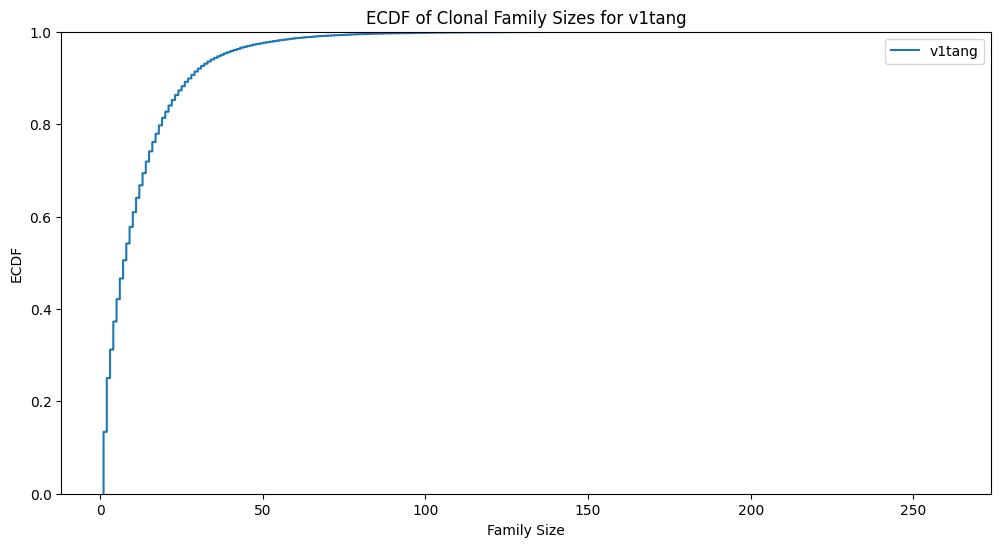

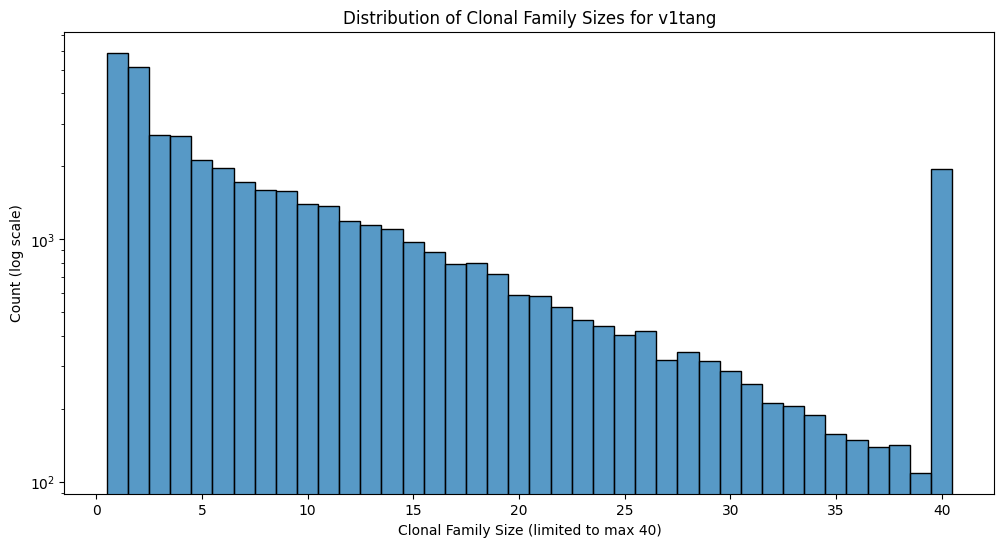

count    43991.000000
mean        11.879248
std         14.100789
min          1.000000
25%          2.000000
50%          7.000000
75%         16.000000
max        261.000000
dtype: float64

In [13]:
def descriptive_stats_of_nickname(nickname):
    pcp_df = pcp_df_of_nickname(nickname, add_shm_outputs=False)
    
    family_sizes = pcp_df.groupby("family").size().sort_values()

    # ECDF plot of family sizes
    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=family_sizes, label=nickname)
    plt.xlabel('Family Size')
    plt.ylabel('ECDF')
    plt.title(f'ECDF of Clonal Family Sizes for {nickname}')
    plt.legend()
    plt.show()
    
    # Descriptive statistics
    stats = family_sizes.describe()

    # Limit family sizes to a max of 40 for the histogram
    limited_family_sizes = family_sizes.clip(upper=40)
    
    # Scatter plot of clonal family sizes with log-scaled y-axis
    plt.figure(figsize=(12, 6))
    sns.histplot(limited_family_sizes, bins=np.arange(1, 42) - 0.5, discrete=True)
    plt.yscale('log')
    plt.xlabel('Clonal Family Size (limited to max 40)')
    plt.ylabel('Count (log scale)')
    plt.title(f'Distribution of Clonal Family Sizes for {nickname}')
    plt.show()
    
    return stats

descriptive_stats_of_nickname("v1tang")

Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


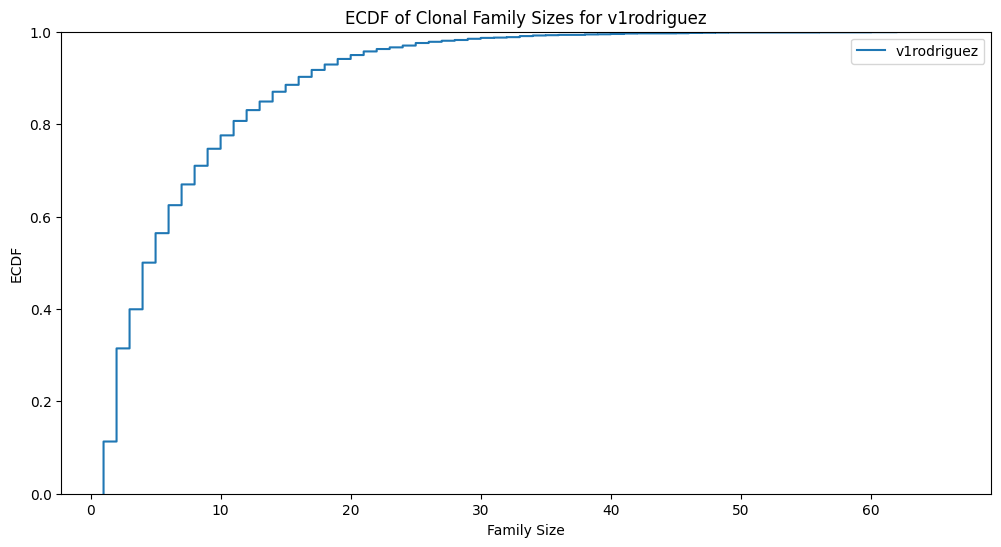

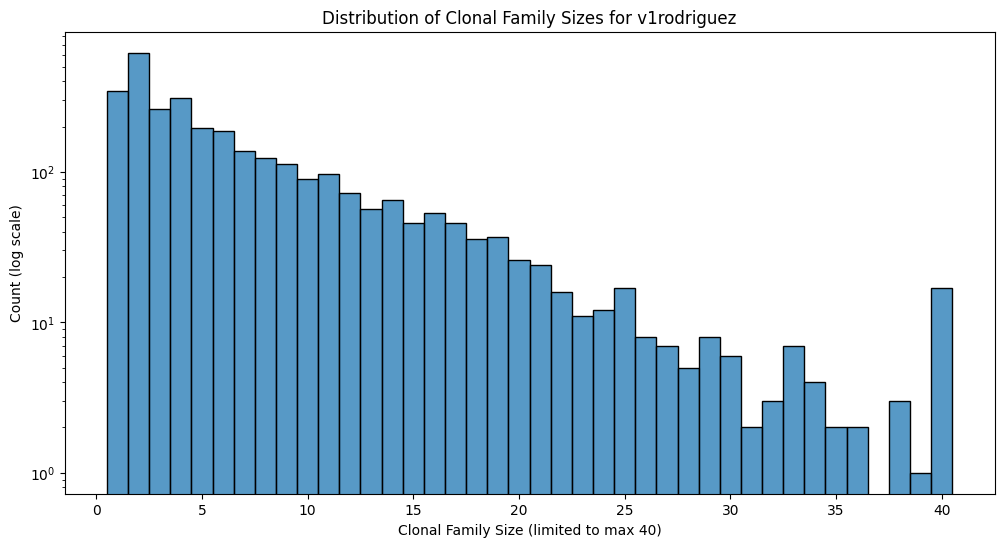

count    3071.000000
mean        7.083035
std         7.125031
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max        66.000000
dtype: float64

In [14]:
descriptive_stats_of_nickname("v1rodriguez")